#AlphaFold - single sequence input


In [2]:
# @title CODE
import os
import sys
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import tqdm.notebook

# Configuration
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

@dataclass
class FoldingResult:
    """Data class to store folding results"""
    sequence: str
    length: int
    recycles: int
    mean_plddt: float
    min_plddt: float
    max_plddt: float
    mean_pae: float
    final_positions: np.ndarray
    plddt_scores: np.ndarray
    pae_matrix: np.ndarray
    execution_time: float

class ColabFoldRunner:
    """Refactored ColabFold runner for batch processing"""

    def __init__(self, verbose: bool = True):
        self.verbose = verbose
        self.setup_done = False

        # Model components
        self.model_runner = None
        self.model_params = None

        # Current model state
        self.current_max_length = 0
        self.runner_fn = None

        # Sequence processing cache
        self.current_sequence = ""
        self.sequence_cache = None

    def _print(self, *args, **kwargs):
        """Print only if verbose mode is enabled"""
        if self.verbose:
            print(*args, **kwargs)

    def setup_environment(self):
        """Setup the environment and download required files"""
        if self.setup_done:
            return

        self._print("Setting up ColabFold environment...")

        # Download and setup ColabFold if not already done
        if not os.path.isdir("params"):
            os.system("wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py")
            self._print("Installing ColabDesign...")
            os.system("(mkdir params; apt-get install aria2 -qq; \
            aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar; \
            tar -xf alphafold_params_2021-07-14.tar -C params; \
            touch params/done.txt)&")

            os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@beta")
            os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

            # Wait for params download
            if not os.path.isfile("params/done.txt"):
                self._print("Downloading AlphaFold params...")
                while not os.path.isfile("params/done.txt"):
                    time.sleep(5)

        # Import libraries after installation
        import jax
        import jax.numpy as jnp
        from colabdesign.af.loss import get_plddt, get_pae
        from colabdesign.af.prep import prep_input_features
        from colabdesign.af.inputs import update_seq, update_aatype
        from colabdesign.af.alphafold.common import protein
        from colabdesign.af.alphafold.model import data, config, model
        from colabdesign.af.alphafold.common import residue_constants
        from colabdesign.rf.utils import make_animation
        import py3Dmol
        import colabfold as cf

        # Store imports as globals for use in other methods
        globals()['jax'] = jax
        globals()['jnp'] = jnp
        globals()['get_plddt'] = get_plddt
        globals()['get_pae'] = get_pae
        globals()['prep_input_features'] = prep_input_features
        globals()['update_seq'] = update_seq
        globals()['update_aatype'] = update_aatype
        globals()['protein'] = protein
        globals()['data'] = data
        globals()['config'] = config
        globals()['model'] = model
        globals()['residue_constants'] = residue_constants
        globals()['cf'] = cf

        # Configure device
        if int(jax.__version__.split(".")[1]) > 3:
            os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"

        try:
            import jax.tools.colab_tpu
            jax.tools.colab_tpu.setup_tpu()
            self._print('Running on TPU')
        except:
            if jax.local_devices()[0].platform == 'cpu':
                self._print("WARNING: no GPU detected, will be using CPU")
            else:
                self._print('Running on GPU')

        # Setup model configuration
        cfg = config.model_config("model_5_ptm")
        cfg.model.num_recycle = 0
        cfg.model.global_config.subbatch_size = None

        model_name = "model_2_ptm"
        self.model_params = data.get_model_haiku_params(
            model_name=model_name, data_dir=".", fuse=True
        )
        self.model_runner = model.RunModel(cfg, self.model_params)

        self.setup_done = True

    def _process_sequence(self, sequence: str) -> Tuple[str, str, List[int], int]:
        """Process and validate input sequence"""
        # Clean sequence - remove non-standard characters but keep chain separators
        clean_seq = re.sub(r"[^A-Z/:]+", "", sequence.upper())

        # Calculate chain breaks (positions where chains end)
        chains = clean_seq.replace(":", "/").split("/")
        chain_lengths = [len(chain) for chain in chains]

        # Final sequence with only amino acids
        final_seq = re.sub(r"[^A-Z]+", "", clean_seq)
        length = len(final_seq)

        if length == 0:
            raise ValueError("Empty sequence after cleaning")

        return clean_seq, final_seq, chain_lengths, length

    def _ensure_model_capacity(self, required_length: int):
        """Ensure model can handle sequences of required length"""
        if required_length > self.current_max_length:
            new_max_length = required_length + 10  # Add padding
            self._setup_model_for_length(new_max_length)

    def _setup_model_for_length(self, max_length: int):
        """Setup JAX-compiled model runner for specific max length"""
        self._print(f"Setting up model for max length: {max_length}")

        def runner(inputs_dict):
            """Inner function that will be JIT compiled"""
            # Unpack inputs
            inputs = inputs_dict["inputs"]
            prev_state = inputs_dict["prev"]
            seq = inputs_dict["seq"]
            length = inputs_dict["length"]

            # Update inputs with current sequence
            inputs["prev"] = prev_state

            # Convert sequence to one-hot encoding
            seq_oh = jax.nn.one_hot(seq, 20)[None]
            update_seq(seq_oh, inputs)
            update_aatype(seq_oh, inputs)

            # Create mask for actual sequence length
            mask = jnp.arange(inputs["residue_index"].shape[0]) < length
            inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
            inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
            inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

            # Run prediction
            key = jax.random.PRNGKey(0)
            outputs = self.model_runner.apply(inputs_dict["params"], key, inputs)

            # Extract relevant outputs
            return {
                "final_atom_positions": outputs["structure_module"]["final_atom_positions"],
                "final_atom_mask": outputs["structure_module"]["final_atom_mask"],
                "plddt": get_plddt(outputs),
                "pae": get_pae(outputs),
                "prev": outputs["prev"],
                "residue_idx": inputs["residue_index"]
            }

        # Compile the runner
        self.runner_fn = jax.jit(runner)
        self.current_max_length = max_length

    def _prepare_inputs(self, sequence: str, chain_lengths: List[int], max_length: int) -> Dict:
        """Prepare input features for the model"""
        # Convert sequence to integer array
        seq_array = np.array([
            residue_constants.restype_order.get(aa, 0)
            for aa in sequence
        ])
        # Pad to max_length
        seq_padded = np.pad(seq_array, [0, max_length - len(sequence)], constant_values=-1)

        # Create fresh input features for this length
        inputs = prep_input_features(max_length)
        inputs["use_dropout"] = False

        # Set chain break indices
        inputs['residue_index'][:] = cf.chain_break(
            np.arange(max_length), chain_lengths, length=32
        )

        # Create input dictionary
        return {
            "inputs": inputs,
            "params": self.model_params,
            "seq": seq_padded,
            "length": len(sequence),
            "prev": {
                'prev_msa_first_row': np.zeros([max_length, 256]),
                'prev_pair': np.zeros([max_length, max_length, 128]),
                'prev_pos': np.zeros([max_length, 37, 3])
            }
        }

    def save_pdb(self, outputs: Dict, sequence_length: int, filename: str):
        """Save PDB coordinates"""
        pdb_data = {
            "residue_index": outputs["residue_idx"][:sequence_length] + 1,
            "aatype": outputs["seq"][:sequence_length],
            "atom_positions": outputs["final_atom_positions"][:sequence_length],
            "atom_mask": outputs["final_atom_mask"][:sequence_length],
            "plddt": outputs["plddt"][:sequence_length]
        }

        b_factors = 100 * pdb_data["plddt"][:, None] * pdb_data["atom_mask"]
        protein_obj = protein.Protein(
            atom_positions=pdb_data["atom_positions"],
            atom_mask=pdb_data["atom_mask"],
            aatype=pdb_data["aatype"],
            residue_index=pdb_data["residue_index"],
            b_factors=b_factors
        )

        pdb_lines = protein.to_pdb(protein_obj)
        with open(filename, 'w') as f:
            f.write(pdb_lines)

    def fold_sequence(self, sequence: str, recycles: int = 0, save_pdb_file: Optional[str] = None) -> FoldingResult:
        """Fold a single sequence and return results"""
        start_time = time.time()

        # Process and validate sequence
        clean_seq, final_seq, chain_lengths, length = self._process_sequence(sequence)

        # Ensure model can handle this sequence length
        self._ensure_model_capacity(length)

        # Check if we need to reprocess this sequence
        if clean_seq != self.current_sequence:
            self._print(f"Processing new sequence (L={length})")

            # Prepare model inputs
            model_inputs = self._prepare_inputs(final_seq, chain_lengths, self.current_max_length)

            # Initialize storage for this sequence
            self.sequence_cache = {
                "sequence": clean_seq,
                "final_seq": final_seq,
                "length": length,
                "model_inputs": model_inputs,
                "positions": [],
                "plddts": [],
                "paes": [],
                "outputs": []
            }
            self.current_sequence = clean_seq

        # Get cached data
        cache = self.sequence_cache

        # Run additional recycles if needed
        current_recycles = len(cache["outputs"])

        if self.verbose and recycles >= current_recycles:
            progress_bar = tqdm.notebook.tqdm(
                total=recycles + 1 - current_recycles,
                bar_format=TQDM_BAR_FORMAT,
                desc=f"Folding (L={length}, cycles {current_recycles}->{recycles})"
            )
        else:
            progress_bar = None

        # Run folding for required recycles
        for cycle in range(current_recycles, recycles + 1):
            # Run model
            outputs = self.runner_fn(cache["model_inputs"])
            outputs = jax.tree_util.tree_map(lambda x: np.asarray(x), outputs)

            # Store results (only the actual sequence length)
            cache["positions"].append(outputs["final_atom_positions"][:length])
            cache["plddts"].append(outputs["plddt"][:length])
            cache["paes"].append(outputs["pae"][:length, :length])
            cache["outputs"].append(outputs)

            # Update previous state for next cycle
            cache["model_inputs"]["prev"] = outputs["prev"]

            if progress_bar:
                progress_bar.update(1)

        if progress_bar:
            progress_bar.close()

        # Get final results
        final_plddt = cache["plddts"][recycles]
        final_pae = cache["paes"][recycles]
        final_output = cache["outputs"][recycles]

        # Calculate statistics
        mean_plddt = float(np.mean(final_plddt))
        min_plddt = float(np.min(final_plddt))
        max_plddt = float(np.max(final_plddt))
        mean_pae = float(np.mean(final_pae))

        execution_time = time.time() - start_time

        # Save PDB if requested
        if save_pdb_file:
            # Add sequence info to outputs for PDB saving
            final_output_for_pdb = final_output.copy()
            final_output_for_pdb["seq"] = cache["model_inputs"]["seq"]
            self.save_pdb(final_output_for_pdb, length, save_pdb_file)

        return FoldingResult(
            sequence=final_seq,
            length=length,
            recycles=recycles,
            mean_plddt=mean_plddt,
            min_plddt=min_plddt,
            max_plddt=max_plddt,
            mean_pae=mean_pae,
            final_positions=cache["positions"][recycles],
            plddt_scores=final_plddt,
            pae_matrix=final_pae,
            execution_time=execution_time
        )

    def fold_sequences_batch(self, sequences: List[str], recycles: int = 0,
                           save_pdbs: bool = False) -> List[FoldingResult]:
        """Fold multiple sequences and return results"""
        results = []

        self._print(f"Folding {len(sequences)} sequences with {recycles} recycles...")

        for i, seq in enumerate(sequences):
            if self.verbose:
                print(f"\nProcessing sequence {i+1}/{len(sequences)}")

            pdb_file = f"structure_{i+1}.pdb" if save_pdbs else None

            try:
                result = self.fold_sequence(seq, recycles, pdb_file)
                results.append(result)

                if self.verbose:
                    print(f"Completed: Length={result.length}, "
                          f"Mean pLDDT={result.mean_plddt:.2f}, "
                          f"Mean PAE={result.mean_pae:.2f}, "
                          f"Time={result.execution_time:.1f}s")
            except Exception as e:
                self._print(f"Error processing sequence {i+1}: {e}")
                # Continue with next sequence
                continue

        return results

    def get_summary_dataframe(self, results: List[FoldingResult]) -> pd.DataFrame:
        """Convert results to a summary DataFrame"""
        summary_data = []

        for i, result in enumerate(results):
            summary_data.append({
                'Sequence_ID': i + 1,
                'Length': result.length,
                'Recycles': result.recycles,
                'Mean_pLDDT': result.mean_plddt,
                'Min_pLDDT': result.min_plddt,
                'Max_pLDDT': result.max_plddt,
                'Mean_PAE': result.mean_pae,
                'Execution_Time_s': result.execution_time,
                'Sequence': result.sequence[:50] + ('...' if len(result.sequence) > 50 else '')
            })

        return pd.DataFrame(summary_data)

In [3]:
%%writefile seqs.txt
MAEELAAKQKLEELEKQLEQLEQAVGGGGSAAKQKLEELEKQLEQLEQAVGGGGSAAKQKLEELEKQLEQLEQAVGGGGSAAKQKLEELEKQLEQLEQAV
MALIKALEKELAALEKIAAAAGGGGSMALIKALEKELAALEKIAAAAGGGGSMALIKALEKELAALEKIAAAAGGGGSMALIKALEKELAALEKIAAAA
MALIQKLEEKLLEIAKELLAAGGGTELIKKLEEKLLKIAKDLLEAGGGTEAIQKLEEKLLEIAKELLAAGGGTELIKKLEEKLLKIAKDLLEA
MSNLEIKKLIEELVKIAALGGGSGQLEIRKELLEILKQLVAEGGGSDNLKQIKELLEALKRILEAGGGSEKLQKLEELVEAIEQLVAA
MSNLEIKKLIEELVKIAALGPGDQLKIRKELLEILKQLVAEGPNDNLEQIKELLEALKRILEAGPGSEKLQKLEELVEAIEQLVAA
MLAQIEAKLAQIEAKLAQIEAKLAQIEAKGSGSLAQIEAKLAQIEAKLAQIEAKLAQIEAKGSGSLAQIEAKLAQIEAKLAQIEAKLAQIEAKGSGSLAQIEAKLAQIEAKLAQIEAKLAQIEAK
EIAALEAKNAALKAEIAALEAKNAALKGPGTGELAAEAEQLARLEELVEEALEQLARELGPGTGEIAALEAKNAALKAEIAALEAKNAALKGPGTGELAAEAEQLARLEELVEEALEQLAREL
NEIAALEAKNAALKAEIAALEAKNAALKDSGSGNELKALEEAQLKAQELEAQLKAQELEAQDDSGSGNEIAALEAKNAALKAEIAALEAKNAALKDSGSGNELKALEEAQLKAQELEAQLKAQELEAQDD
CEAIALKFEAIALKFEAIALKFEAIALKFEAIALKSGSGIQELKQEIQELKQEIQELKQEIQELKQEIQELKQESGSGCEAIALKFEAIALKFEAIALKFEAIALKFEAIALKSGSGIQELKQEIQELKQEIQELKQEIQELKQEIQELKQE
NCEAIALKFEAIALKFEAIALKFEAIALKFEAIALKDDPPTCNIQELKQEIQELKQEIQELKQEIQELKQEIQELKQEDDDPPTNCEAIALKFEAIALKFEAIALKFEAIALKFEAIALKDDPPTCNIQELKQEIQELKQEIQELKQEIQELKQEIQELKQEDD
LKALEKELKALEKELKALEKELKALEKEGGPGSIKALEQKIKALEQKIKALEQKIKALEQKGGTGSLKALEKELKALEKELKALEKELKALEKEGGAGTIKALEQKIKALEQKIKALEQKIKALEQK
LKALEKLKALEKLKALEKLKALEKLGGPGSIQALERIQALERIQALERIQALERIQGGPGSLKALEELKALEELKALEELKALEELGGPGSVQALDKVQALDKVQALDKVQALDKVQ
MQEERKKLLEKLEKILDEVTDGAPDEARERIEKLAKDVKDELEEGDAKNMIEKFRDEMEQMYKDAPNAVMEQLLEEIEKLLKKA
MAEAAEKLKEALKEALKEAGGGSAEAAEKLKEALKEALKEAGGGSAEAAEKLKEALKEALKEAGGGSAEAAEKLKEALKEALKEA
MEIAALEKEIAALEKEIAALEKEIAALEKGPGEIAALEKEIAALEKEIAALEKEIAALEKGPGEIAALEKEIAALEKEIAALEKEIAALEKGPGEIAALEKEIAALEKEIAALEKEIAALEK
MEIAALEKEIAALEKEIAALEKEIAALEKGGSGGKIAALKEKIAALKEKIAALKEKIAALKEGGSGGEIAALEKEIAALEKEIAALEKEIAALEKGGSGGKIAALKEKIAALKEKIAALKEKIAALKE
MLKALEQKLKALEQKLKALEQKGGGSGLKALEQKLKALEQKLKALEQKGGGSGLKALEQKLKALEQKLKALEQKGGGSGLKALEQKLKALEQKLKALEQK
TLKQLEAKLKQLEAKLKQLEAKNGGSGTLKQLEAKLKQLEAKLKQLEAKNGGSGTLKQLEAKLKQLEAKLKQLEAKNGGSGTLKQLEAKLKQLEAKLKQLEAKN
MLKAIEAKLKAIEAKLKAIEAKGGGSGLKAIEAKLKAIEAKLKAIEAKGGGSGLKAIEAKLKAIEAKLKAIEAKGGGSGLKAIEAKLKAIEAKLKAIEAK
MAEELKKLAEELKRLAEELKKLAGGGSGAEELKKLAEELKRLAEELKKLAGGGSGAEELKKLAEELKRLAEELKKLAGGGSGAEELKKLAEELKRLAEELKKLA
MIEALAKKIEALAKKIEALAKKIEALAKKGGSGLEALAKKLEALAKKLEALAKKLEALAKKGGSGIEALSKKIEALSKKIEALSKKIEALSKKGGSGLEALSKKLEALSKKLEALSKKLEALSKK
LAEIAKELAEIAKELAEIAKELAEIAKEGSGGGLKEIAELLKEIAELLKEIAELLKEIAELGSGGGLAKVAELLAKVAELLAKVAELLAKVAELGSGGGLAEVAKLLAEVAKLLAEVAKLLAEVAKL
LKALEEKLKALEEKLKALEEKGPGSIEAIEELIEAIEELIEAIEELGPGSLQKALENLQKALENLQKALENGPGSIEAIEELIEAIEELIEAIEEL
LEAIKSELEAIKSELEAIKSEGGGSGGVEALRAEVEALRAEVEALRAEGGGSGGLDAIRNELDAIRNELDAIRNEGGGSGGLEAIKSELEAIKSELEAIKSE
EIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEK
EIAALEKEIAALEKEIAALEKGGEIQALEQEIQALEQEIQALEKGGEISALEREISALEREISALERGGEIQALEKEIQALEKEIQALEK
MKALEEKIAKLAEKLAAEIKKAGGGEIAKLAEKIAKLAAEKIGGGEKLAEKIAKLAEKLAAEIKK
MKALEEKIAKLAAEKLAKGGGEIAKKLAEKIAEALGGGKIAEKLAKELAEKLAAGGGEKIAKELAKALAEKLAA
MKALEEKIAKLAAEKLAKGGPEIAKKLAEKIAEALGGPKIAEKLAKELAEKLAAGGPEKIAKELAKALAEKLAA
MKALEEAIKKLAAEKLAKGGPQIAEKLAEKIAEALGGPKLAEKIAKELAAKLAGGPEKLAKEIAKALAEKLAA
MLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEK
MDLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIKEKGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIKEKGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIKEKGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIKEK
MDNSLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIEEGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIEEGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIEEGNGSGLEKIKEKLEKIKENPLEKIKEKLEKIKEKLEKIKEKLEKIEE
MDNSLEKIKEKLEKIKEKLEKIKEKLEKIKEKEGNGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKEGNGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKEGNGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKE
MLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKGGGSGLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEKLEKIKEK
MEAAAKELQALEKQALQAELQAELQGGSGEAAAKELQALEKQALQAELQAELQGGSGEAAAKELQALEKQALQAELQAELQGGSGEAAAKELQALEKQALQAELQAELQ
GEIAALEAKNAALKAEIAALEAKIAALKAEIGGGSGGEIAALEAKNAALKAEIAALEAKIAALKAEIGGGSGGEIAALEAKNAALKAEIAALEAKIAALKAEIGGGSGGEIAALEAKNAALKAEIAALEAKIAALKAEI
MEIAALEKEIAALEKEIAALEKEIAALEKGGSGGEIAALEKEIAALEKEIAALEKEIAALEKGGSGGEIAALEKEIAALEKEIAALEKEIAALEKGGSGGEIAALEKEIAALEKEIAALEKEIAALEK
MGLKAIAEKLKAIAEKLKAIAEKLKAIAEKGSGSLKAIAEKLKAIAEKLKAIAEKLKAIAEKGSGSLKAIAEKLKAIAEKLKAIAEKLKAIAEKGSGSLKAIAEKLKAIAEKLKAIAEKLKAIAEK
EIAALEKEIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEKEIAALEKGGSGEIAALEKEIAALEKEIAALEKEIAALEK

Writing seqs.txt


In [4]:
# Initialize the runner
runner = ColabFoldRunner(verbose=False)
runner.setup_environment()

0.6145738959312439


<Figure size 640x480 with 0 Axes>

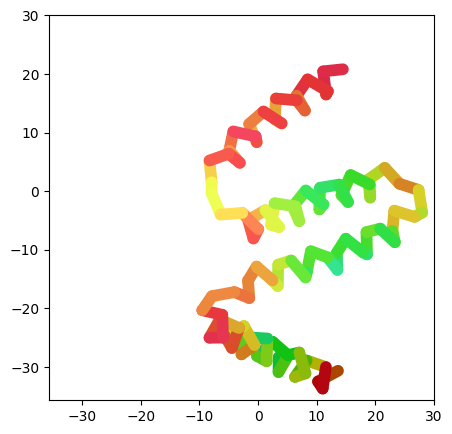

0.6274347305297852


<Figure size 640x480 with 0 Axes>

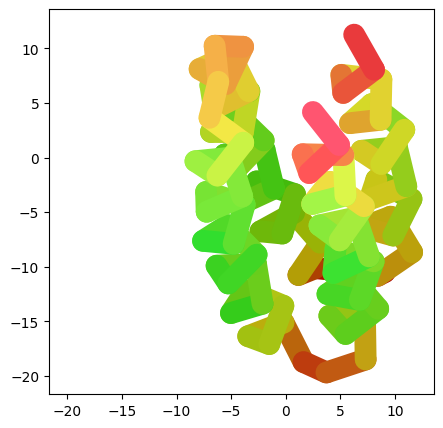

0.6362240314483643


<Figure size 640x480 with 0 Axes>

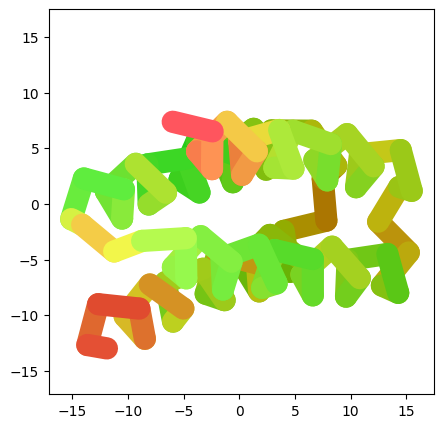

0.6369565725326538


<Figure size 640x480 with 0 Axes>

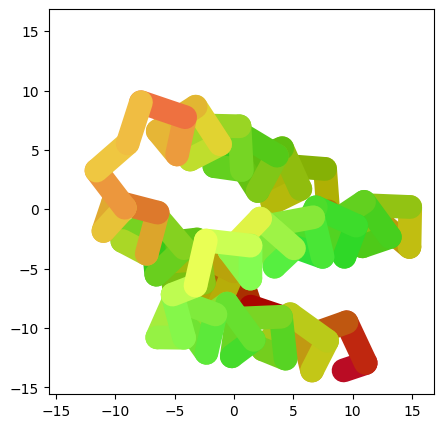

0.595639169216156


<Figure size 640x480 with 0 Axes>

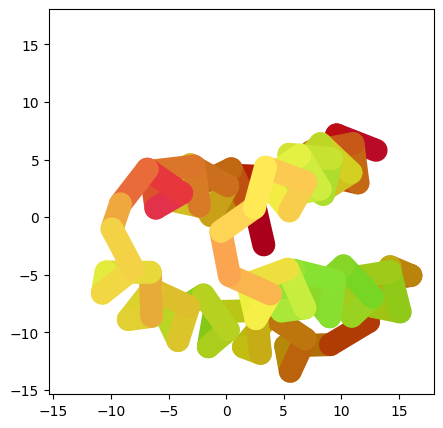

0.9237234592437744


<Figure size 640x480 with 0 Axes>

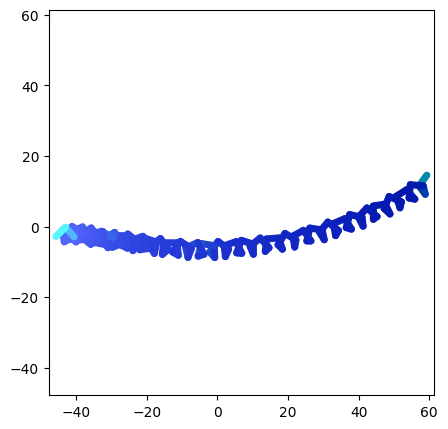

0.5679236650466919


<Figure size 640x480 with 0 Axes>

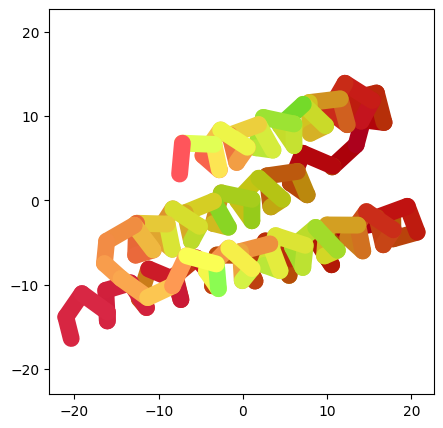

0.5737317800521851


<Figure size 640x480 with 0 Axes>

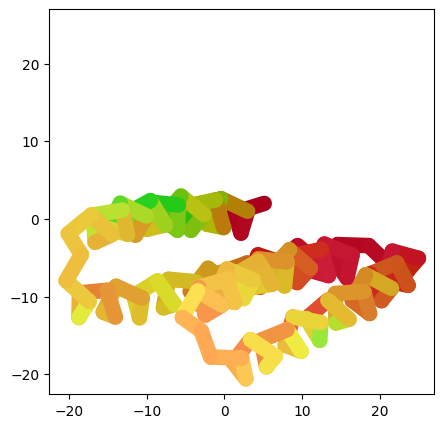

0.5064882636070251


<Figure size 640x480 with 0 Axes>

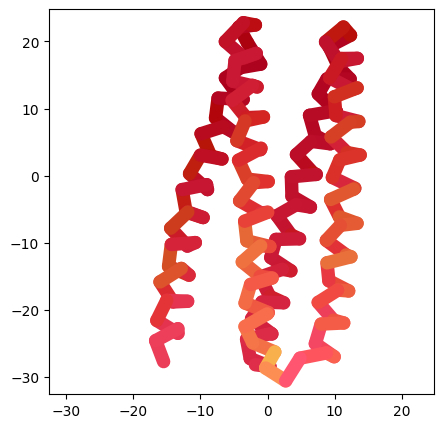

0.6104497313499451


<Figure size 640x480 with 0 Axes>

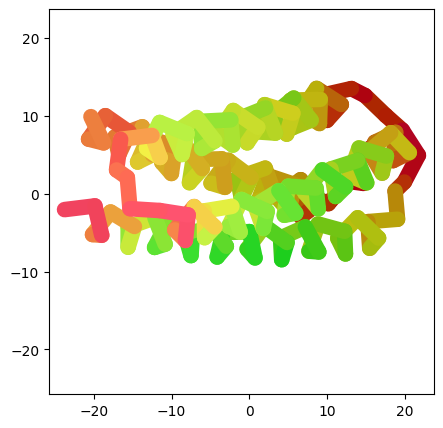

0.688208818435669


<Figure size 640x480 with 0 Axes>

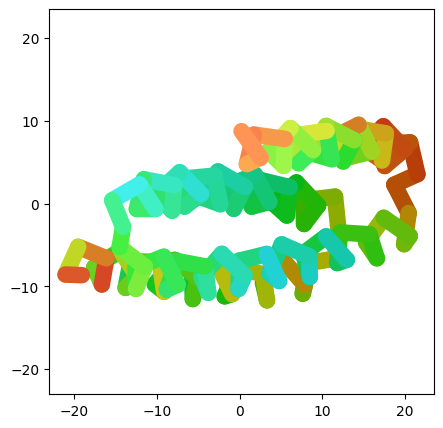

0.5609564781188965


<Figure size 640x480 with 0 Axes>

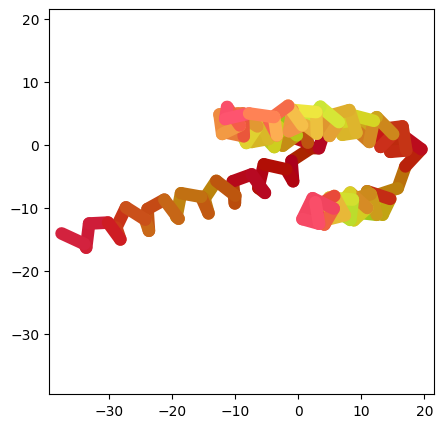

0.7634605169296265


<Figure size 640x480 with 0 Axes>

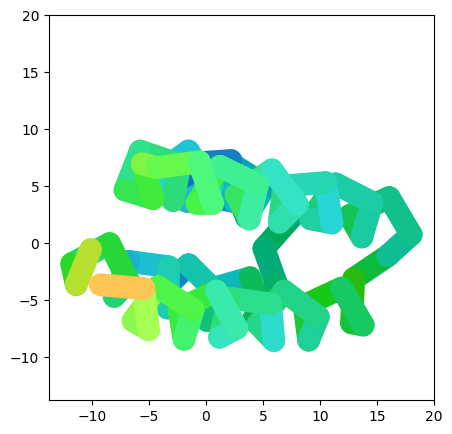

0.6986543536186218


<Figure size 640x480 with 0 Axes>

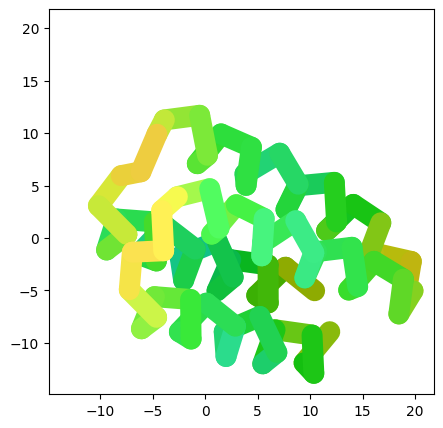

0.7930391430854797


<Figure size 640x480 with 0 Axes>

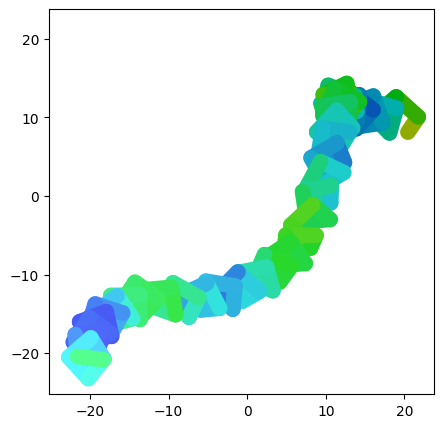

0.8762446641921997


<Figure size 640x480 with 0 Axes>

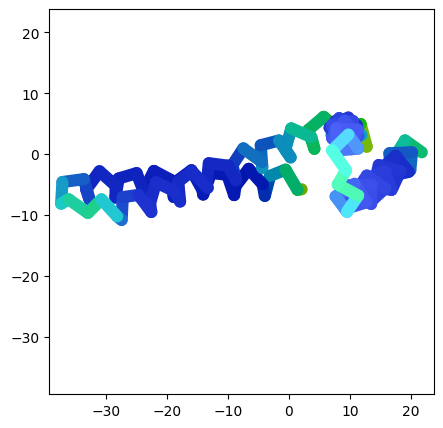

0.7923358082771301


<Figure size 640x480 with 0 Axes>

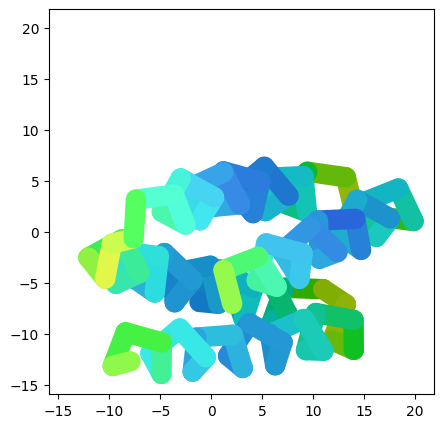

0.6751974821090698


<Figure size 640x480 with 0 Axes>

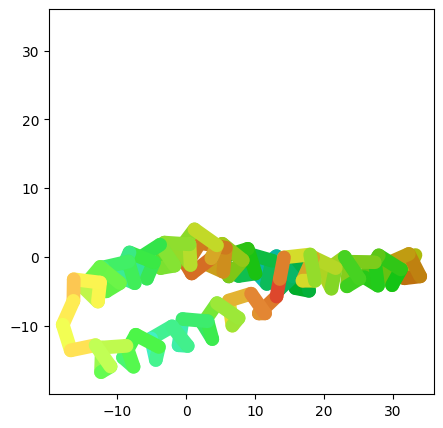

0.6656326055526733


<Figure size 640x480 with 0 Axes>

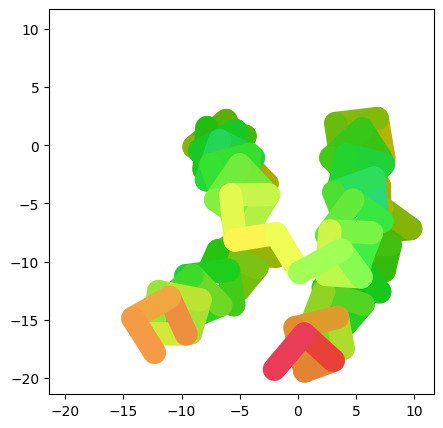

0.8913217782974243


<Figure size 640x480 with 0 Axes>

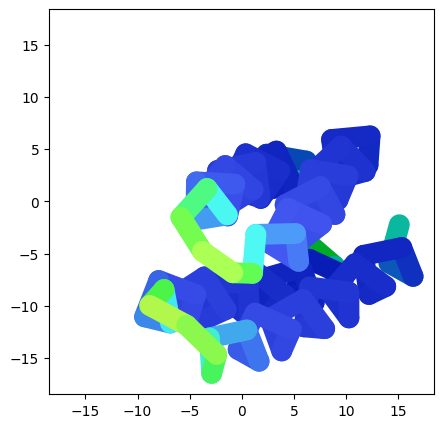

0.8007537126541138


<Figure size 640x480 with 0 Axes>

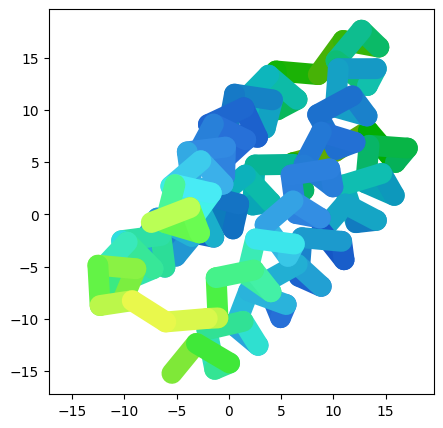

0.8452176451683044


<Figure size 640x480 with 0 Axes>

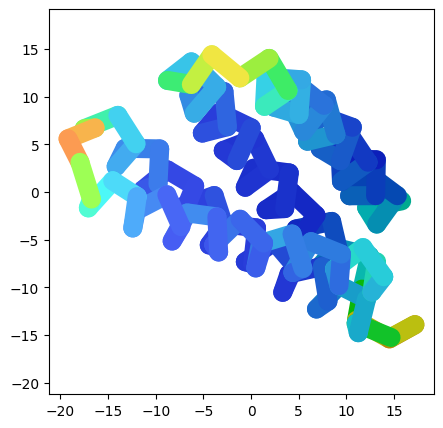

0.811215877532959


<Figure size 640x480 with 0 Axes>

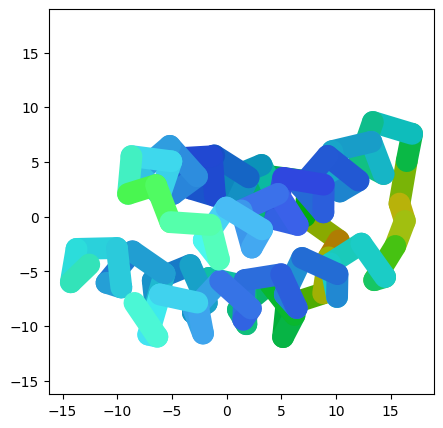

0.8435125350952148


<Figure size 640x480 with 0 Axes>

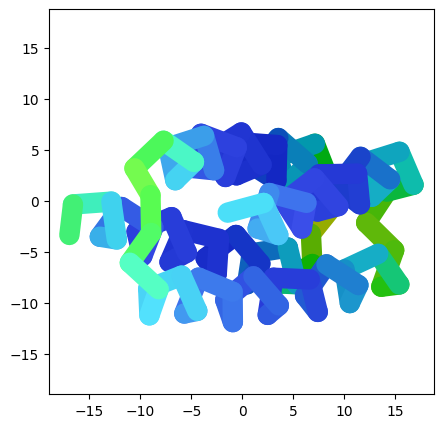

0.8666664958000183


<Figure size 640x480 with 0 Axes>

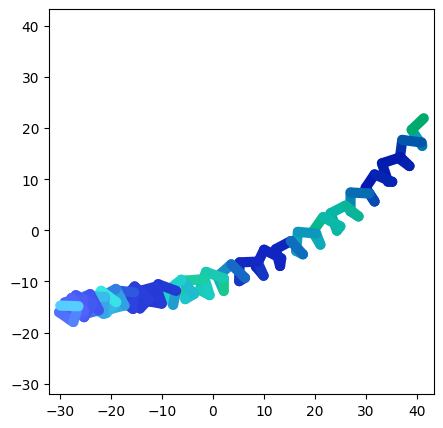

0.7753336429595947


<Figure size 640x480 with 0 Axes>

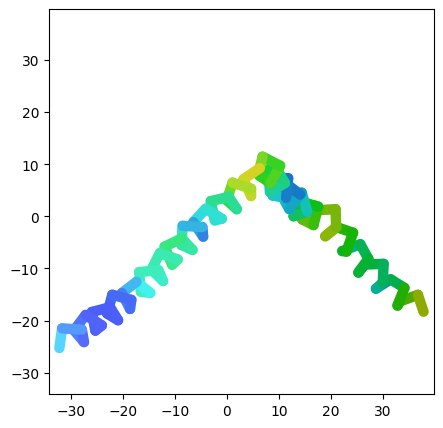

0.6613048315048218


<Figure size 640x480 with 0 Axes>

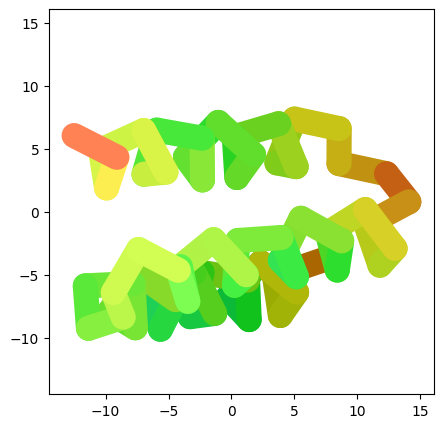

0.6228164434432983


<Figure size 640x480 with 0 Axes>

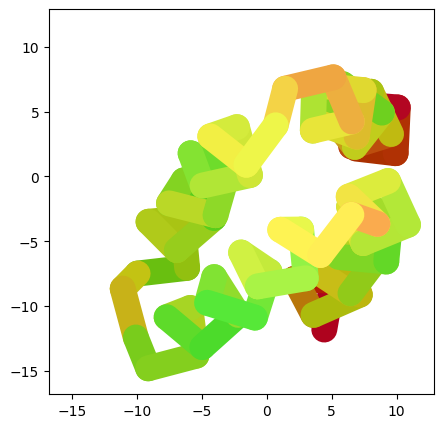

0.6581891775131226


<Figure size 640x480 with 0 Axes>

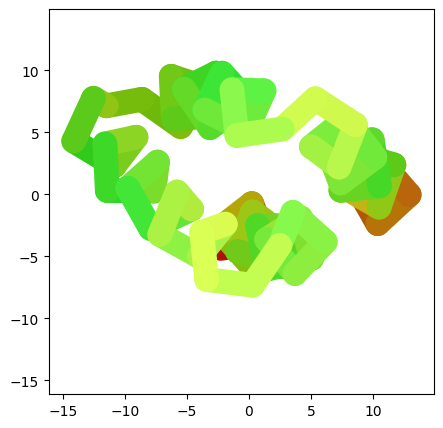

0.61386638879776


<Figure size 640x480 with 0 Axes>

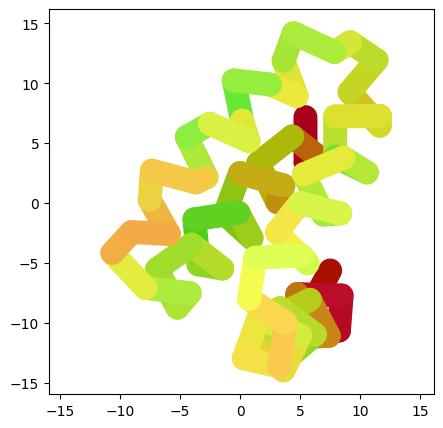

0.8164156079292297


<Figure size 640x480 with 0 Axes>

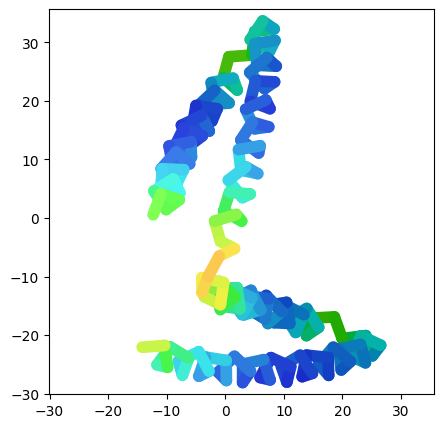

0.5791894197463989


<Figure size 640x480 with 0 Axes>

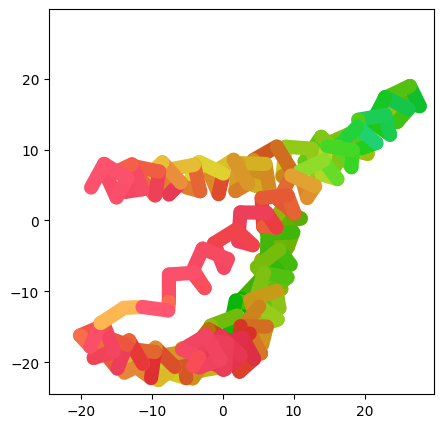

0.6930962204933167


<Figure size 640x480 with 0 Axes>

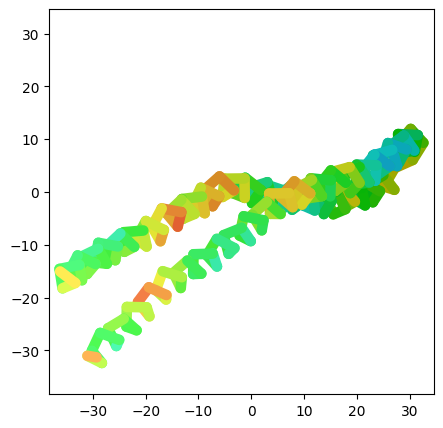

0.5155742168426514


<Figure size 640x480 with 0 Axes>

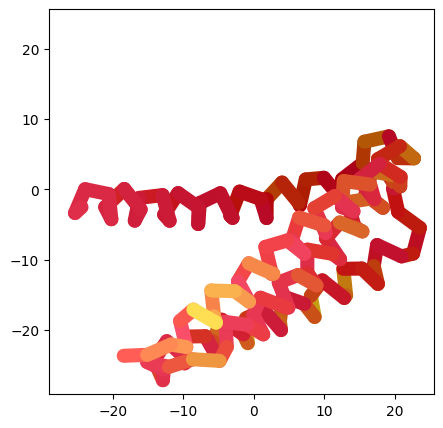

0.82407146692276


<Figure size 640x480 with 0 Axes>

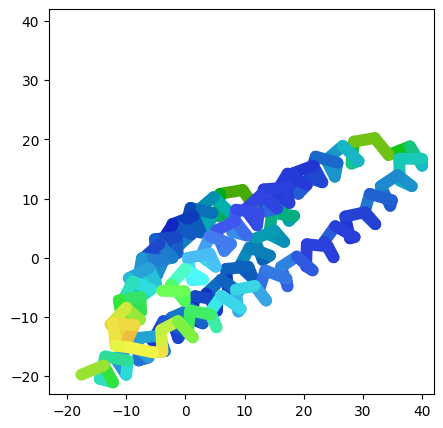

0.5980289578437805


<Figure size 640x480 with 0 Axes>

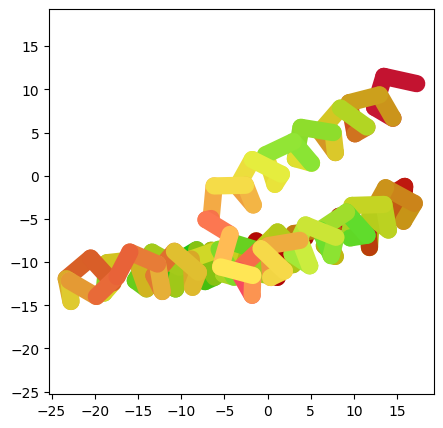

0.6388046741485596


<Figure size 640x480 with 0 Axes>

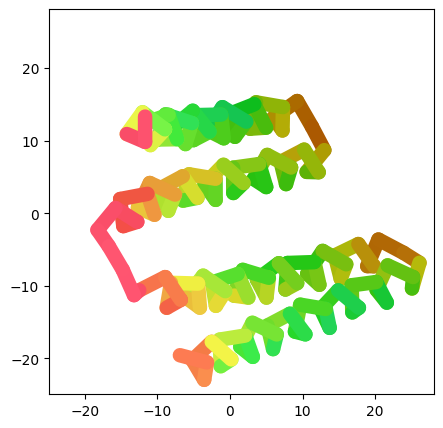

0.7822316884994507


<Figure size 640x480 with 0 Axes>

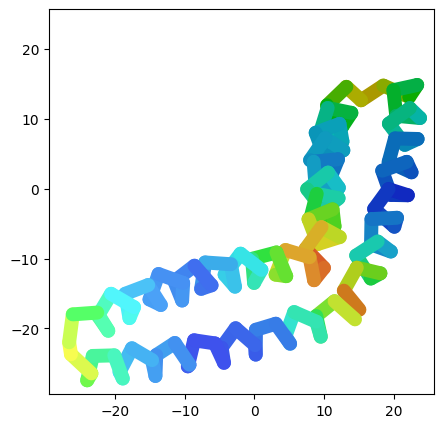

0.8873701095581055


<Figure size 640x480 with 0 Axes>

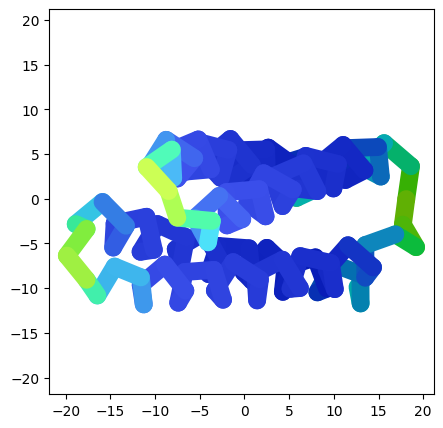

0.8693392872810364


<Figure size 640x480 with 0 Axes>

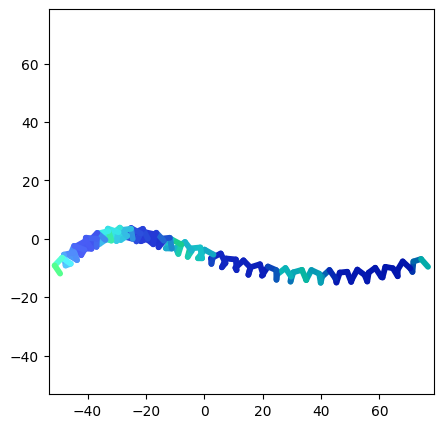

In [ ]:
for seq in open("seqs.txt"):
  seq = seq.rstrip()
  result = runner.fold_sequence(seq, recycles=0)
  print(result.mean_plddt)
  plt.figure()
  cf.plot_pseudo_3D(result.final_positions[:,1,:], c=result.plddt_scores, cmin=0.5, cmax=0.9)
  plt.show()